In [1]:
import torch
from torchvision import datasets

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from utils import label2one_hot
from generate_data import generate_data, generate_grid_data
from modules import Dropout
from modules import Linear, Sequential
import modules
from modules.losses import LossMSE, LossCrossEntropy
from optimizers import SGD
from keras.layers.core import Dense
from keras.models import Sequential
from keras import optimizers


Using TensorFlow backend.
/Users/arasmumcuyan/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
def convert_to_one_hot_labels(input, target, val=0):
    tmp = input.new(target.size(0), target.max() + 1).fill_(-1)
    tmp.scatter_(1, target.view(-1, 1), 1.0)
    if val == 0:      
        ret = (tmp+1)/2
    if val == -1:
        ret = tmp
    return ret

def load_data(one_hot_labels = False, normalize = False, flatten = True, data_dir = None, cifar = False, full = True, tiny = False, val = 0):

    if data_dir is None:
        """
        data_dir = os.environ.get('PYTORCH_DATA_DIR')
        if data_dir is None:
            data_dir = './data'
        """
        data_dir = './data'
        
    if cifar is not None and cifar:
        print('* Using CIFAR')
        cifar_train_set = datasets.CIFAR10(data_dir + '/cifar10/', train = True, download = True)
        cifar_test_set = datasets.CIFAR10(data_dir + '/cifar10/', train = False, download = True)

        train_input = torch.from_numpy(cifar_train_set.train_data)
        # Dirty hack to handle the change between torchvision 1.0.6 and 1.0.8
        if train_input.size(3) == 3:
            train_input = train_input.transpose(3, 1).transpose(2, 3).float()
        else:
            train_input = train_input.float()
        train_target = torch.LongTensor(cifar_train_set.train_labels)

        test_input = torch.from_numpy(cifar_test_set.test_data).float()
        # Dirty hack to handle the change between torchvision 1.0.6 and 1.0.8
        if test_input.size(3) == 3:
            test_input = test_input.transpose(3, 1).transpose(2, 3).float()
        else:
            test_input = test_input.float()
        test_target = torch.LongTensor(cifar_test_set.test_labels)

    else:
        print('* Using MNIST')
        mnist_train_set = datasets.MNIST(data_dir + '/mnist/', train = True, download = True)
        mnist_test_set = datasets.MNIST(data_dir + '/mnist/', train = False, download = True)

        train_input = mnist_train_set.train_data.view(-1, 1, 28, 28).float()
        train_target = mnist_train_set.train_labels
        test_input = mnist_test_set.test_data.view(-1, 1, 28, 28).float()
        test_target = mnist_test_set.test_labels

    if flatten:
        train_input = train_input.clone().view(train_input.size(0), -1)
        test_input = test_input.clone().view(test_input.size(0), -1)

    if full:
        if tiny:
            raise ValueError('Cannot have both --full and --tiny')
    else:
        if tiny:
            print('** Reduce the data-set to the tiny setup')
            train_input = train_input.narrow(0, 0, 500)
            train_target = train_target.narrow(0, 0, 500)
            test_input = test_input.narrow(0, 0, 100)
            test_target = test_target.narrow(0, 0, 100)
        else:
            print('** Reduce the data-set (use --full for the full thing)')
            train_input = train_input.narrow(0, 0, 1000)
            train_target = train_target.narrow(0, 0, 1000)
            test_input = test_input.narrow(0, 0, 1000)
            test_target = test_target.narrow(0, 0, 1000)

    print('** Use {:d} train and {:d} test samples'.format(train_input.size(0), test_input.size(0)))

    if one_hot_labels:
        train_target = convert_to_one_hot_labels(train_input, train_target, val=val)
        test_target = convert_to_one_hot_labels(test_input, test_target, val=val)

    if normalize:
        mu, std = train_input.mean(), train_input.std()
        train_input.sub_(mu).div_(std)
        test_input.sub_(mu).div_(std)

    return train_input, train_target, test_input, test_target


In [13]:
from keras.datasets import cifar10
def get_cifar():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    print(type(x_train))
    print("x_train.shape: {}".format(x_train.shape))
    


<class 'numpy.ndarray'>
x_train.shape: (50000, 32, 32, 3)


In [4]:
train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True, flatten = True, data_dir = None, cifar = False, full = True, tiny = False, val=0)
train_input_mse, train_target_mse, test_input_mse, test_target_mse = load_data(one_hot_labels = True, normalize = True, flatten = True, data_dir = None, cifar = False, full = True, tiny = False, val=-1)

* Using MNIST
** Use 60000 train and 10000 test samples
* Using MNIST
** Use 60000 train and 10000 test samples


In [5]:
train_target

tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  1.,  0.]])

In [6]:
train_target_mse

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1.,  1., -1.]])

In [7]:
def default_net_1(x_all, y_all, num_of_neurons=(2, 25, 2), activation='relu', lr=0.1, momentum_coef=0.0, weight_decay=0.0, p_dropout=0.0, num_of_epochs=100, val_split=0.2, verbose=0):
    ce = LossCrossEntropy()

    model = Sequential()
    model.add(Linear(out=num_of_neurons[1], input_size=num_of_neurons[0], activation=activation))
    model.add(Dropout(prob=p_dropout))

    model.add(Linear(out=num_of_neurons[2], activation='softmax'))

    model.loss = ce
    sgd = SGD(lr, momentum_coef, weight_decay=weight_decay)

    report = sgd.train(model, x_all, y_all, num_of_epochs, val_split=val_split, verbose=verbose)

    return model, report

def default_net_2(x_all, y_all, num_of_neurons=(2, 25, 25, 2), activation='relu', lr=0.1, momentum_coef=0.0, weight_decay=0.0, p_dropout=0.0, num_of_epochs=100, val_split=0.2, verbose=0):
    ce = LossCrossEntropy()

    model = Sequential()
    model.add(Linear(out=num_of_neurons[1], input_size=num_of_neurons[0], activation=activation))
    model.add(Dropout(prob=p_dropout))
    model.add(Linear(out=num_of_neurons[2], activation=activation))
    model.add(Dropout(prob=p_dropout))

    model.add(Linear(out=num_of_neurons[3], activation='softmax'))

    model.loss = ce
    sgd = SGD(lr, momentum_coef, weight_decay=weight_decay)

    report = sgd.train(model, x_all, y_all, num_of_epochs, val_split=val_split, verbose=verbose)

    return model, report


def default_net_3(x_all, y_all, num_of_neurons=(2, 25, 25, 25, 2), activation='relu', lr=0.1, momentum_coef=0.0, weight_decay=0.0, p_dropout=0.0, num_of_epochs=100, val_split=0.2, verbose=0):
    ce = LossCrossEntropy()

    model = Sequential()
    model.add(Linear(out=num_of_neurons[1], input_size=num_of_neurons[0], activation=activation))
    model.add(Dropout(prob=p_dropout))
    model.add(Linear(out=num_of_neurons[2], activation=activation))
    model.add(Dropout(prob=p_dropout))
    model.add(Linear(out=num_of_neurons[3], activation=activation))
    model.add(Dropout(prob=p_dropout))
    
    model.add(Linear(out=num_of_neurons[4], activation='softmax'))

    model.loss = ce
    sgd = SGD(lr, momentum_coef, weight_decay=weight_decay)

    report = sgd.train(model, x_all, y_all, num_of_epochs, val_split=val_split, verbose=verbose)

    return model, report

def default_net_4(x_all, y_all, num_of_neurons, activation='relu', lr=0.001, momentum_coef=0.0, weight_decay=0.0, p_dropout=0.0, num_of_epochs=100, val_split=0.2, verbose=0):
    # mse = LossMSE()
    ce = LossCrossEntropy()
    
    model = modules.Sequential()
    model.add(Linear(out=num_of_neurons[1], input_size=num_of_neurons[0], activation='relu'))
    # model.add(Dropout(prob=0.2))
    model.add(Linear(out=num_of_neurons[2], activation='relu'))
    # model.add(Dropout(prob=0.2))
    model.add(Linear(out=num_of_neurons[3], activation='relu'))
    # model.add(Dropout(prob=0.2))
    model.add(Linear(out=num_of_neurons[4], activation='softmax'))

    model.loss = ce
    sgd = SGD(lr, momentum_coef, weight_decay=0.0)

    report = sgd.train(model, x_all, y_all, num_of_epochs, val_split=0.2, verbose=0)

    return model, report

def keras_model(x_train, y_train, num_of_neurons):
    model = Sequential([
        Dense(units=num_of_neurons[1], input_dim=x_train.shape[1], activation="relu"),
        Dense(units=num_of_neurons[2], activation="relu"),
        Dense(units=num_of_neurons[3], activation="relu"),
        Dense(units=y_train.shape[1], activation="softmax"),
    ])
    
    sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    hist = model.fit(x_train, y_train, batch_size=128, epochs=50, validation_split=0.2, verbose=2)
    return hist

In [ ]:
num_of_neurons=(784, 500, 200, 100, 10)
hist = keras_model(train_input, train_target, num_of_neurons)
print('type: {}'.format(type(hist)))


In [8]:
def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot(costs, accs, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(costs, label = "test")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(accs, label = "test")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

def plot_v2(train_report, title=""):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(train_report["train_loss"], label = "train")
    ax1.plot(train_report["val_loss"], label = "validation")
    ax2.plot(train_report["train_acc"], label = "train")
    ax2.plot(train_report["val_acc"], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

In [9]:
print(train_input.shape, " -- ", train_target.shape)

model1, train1 = default_net_4(train_input, train_target, num_of_neurons=(784, 500, 200, 100, 10), activation='relu', lr=0.1, momentum_coef=0.0, weight_decay=0.0, p_dropout=0.0, num_of_epochs=40, val_split=0.2, verbose=0)
test1 = model1.evaluate(test_input, test_target, return_pred=True)

torch.Size([60000, 784])  --  torch.Size([60000, 10])
Added Module Name: 0_Linear 
Added Module Name: 1_ReLU 
Added Module Name: 2_Linear 
Added Module Name: 3_ReLU 
Added Module Name: 4_Linear 
Added Module Name: 5_ReLU 
Added Module Name: 6_Linear 
Added Module Name: 7_Softmax 


  0%|          | 0/40 [00:00<?, ?it/s]

x_train.shape: torch.Size([48000, 784]) -- y_train.shape: torch.Size([48000, 10])
x_val.shape: torch.Size([12000, 784]) -- y_val.shape: torch.Size([12000, 10])
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


  2%|▎         | 1/40 [00:03<02:23,  3.69s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 2.2990827560424805
key: train_acc -- value: 0.06716666370630264
key: val_loss -- value: 2.300745964050293
key: val_acc -- value: 0.07074999809265137
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


  5%|▌         | 2/40 [00:07<02:16,  3.60s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 2.2847485542297363
key: train_acc -- value: 0.09329167008399963
key: val_loss -- value: 2.2863521575927734
key: val_acc -- value: 0.09683333337306976
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


  8%|▊         | 3/40 [00:10<02:12,  3.57s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 2.2698192596435547
key: train_acc -- value: 0.13581250607967377
key: val_loss -- value: 2.271375894546509
key: val_acc -- value: 0.13491666316986084
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 10%|█         | 4/40 [00:14<02:09,  3.58s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 2.2537612915039062
key: train_acc -- value: 0.19075000286102295
key: val_loss -- value: 2.2552733421325684
key: val_acc -- value: 0.18850000202655792
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 12%|█▎        | 5/40 [00:18<02:06,  3.60s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 2.2361066341400146
key: train_acc -- value: 0.26112499833106995
key: val_loss -- value: 2.237598419189453
key: val_acc -- value: 0.2601666748523712
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 15%|█▌        | 6/40 [00:21<02:04,  3.65s/it]

torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 2.216449499130249
key: train_acc -- value: 0.33397915959358215
key: val_loss -- value: 2.217960834503174
key: val_acc -- value: 0.33133333921432495
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 18%|█▊        | 7/40 [00:25<02:00,  3.64s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 2.194395065307617
key: train_acc -- value: 0.39810416102409363
key: val_loss -- value: 2.195953130722046
key: val_acc -- value: 0.3943333327770233
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 20%|██        | 8/40 [00:29<01:57,  3.66s/it]

torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 2.1695303916931152
key: train_acc -- value: 0.4638749957084656
key: val_loss -- value: 2.1711530685424805
key: val_acc -- value: 0.45766666531562805
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 22%|██▎       | 9/40 [00:32<01:53,  3.67s/it]

torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 2.141368865966797
key: train_acc -- value: 0.5346875190734863
key: val_loss -- value: 2.1430892944335938
key: val_acc -- value: 0.5245000123977661
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 25%|██▌       | 10/40 [00:36<01:50,  3.68s/it]

torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 2.1093757152557373
key: train_acc -- value: 0.5882291793823242
key: val_loss -- value: 2.1111814975738525
key: val_acc -- value: 0.5763333439826965
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 28%|██▊       | 11/40 [00:40<01:46,  3.68s/it]

torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 2.072875499725342
key: train_acc -- value: 0.6235625147819519
key: val_loss -- value: 2.0747687816619873
key: val_acc -- value: 0.6129166483879089
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 30%|███       | 12/40 [00:44<01:42,  3.67s/it]

torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 2.031118154525757
key: train_acc -- value: 0.6473958492279053
key: val_loss -- value: 2.0331060886383057
key: val_acc -- value: 0.6384166479110718
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 32%|███▎      | 13/40 [00:47<01:38,  3.65s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 1.9834139347076416
key: train_acc -- value: 0.6617083549499512
key: val_loss -- value: 1.9854927062988281
key: val_acc -- value: 0.6554999947547913
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 35%|███▌      | 14/40 [00:50<01:34,  3.63s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 1.9292770624160767
key: train_acc -- value: 0.6746666431427002
key: val_loss -- value: 1.9314850568771362
key: val_acc -- value: 0.6675833463668823
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 38%|███▊      | 15/40 [00:54<01:30,  3.61s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 1.8681524991989136
key: train_acc -- value: 0.6858749985694885
key: val_loss -- value: 1.8705403804779053
key: val_acc -- value: 0.6785833239555359
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 40%|████      | 16/40 [00:57<01:26,  3.59s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 1.7995686531066895
key: train_acc -- value: 0.6960625052452087
key: val_loss -- value: 1.8021743297576904
key: val_acc -- value: 0.690666675567627
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 42%|████▎     | 17/40 [01:00<01:22,  3.57s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 1.7237731218338013
key: train_acc -- value: 0.7053750157356262
key: val_loss -- value: 1.7266769409179688
key: val_acc -- value: 0.6993333101272583
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 45%|████▌     | 18/40 [01:03<01:18,  3.55s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 1.6420282125473022
key: train_acc -- value: 0.7130833268165588
key: val_loss -- value: 1.6452882289886475
key: val_acc -- value: 0.7073333263397217
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 48%|████▊     | 19/40 [01:07<01:14,  3.53s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 1.5561065673828125
key: train_acc -- value: 0.7208333611488342
key: val_loss -- value: 1.559821605682373
key: val_acc -- value: 0.7164166569709778
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 50%|█████     | 20/40 [01:10<01:10,  3.52s/it]

torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 1.4680438041687012
key: train_acc -- value: 0.729729175567627
key: val_loss -- value: 1.4723224639892578
key: val_acc -- value: 0.7260000109672546
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 52%|█████▎    | 21/40 [01:13<01:06,  3.51s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 1.380076289176941
key: train_acc -- value: 0.7401250004768372
key: val_loss -- value: 1.385015606880188
key: val_acc -- value: 0.737333357334137
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 55%|█████▌    | 22/40 [01:17<01:03,  3.51s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 1.2943617105484009
key: train_acc -- value: 0.7528958320617676
key: val_loss -- value: 1.3000553846359253
key: val_acc -- value: 0.750333309173584
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 57%|█████▊    | 23/40 [01:20<00:59,  3.49s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 1.2126805782318115
key: train_acc -- value: 0.7678750157356262
key: val_loss -- value: 1.2192187309265137
key: val_acc -- value: 0.7622500061988831
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 60%|██████    | 24/40 [01:23<00:55,  3.47s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 1.136257290840149
key: train_acc -- value: 0.7797291874885559
key: val_loss -- value: 1.143671989440918
key: val_acc -- value: 0.7735833525657654
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 62%|██████▎   | 25/40 [01:26<00:51,  3.46s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 1.0658680200576782
key: train_acc -- value: 0.7918958067893982
key: val_loss -- value: 1.0741360187530518
key: val_acc -- value: 0.784583330154419
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 65%|██████▌   | 26/40 [01:29<00:48,  3.45s/it]

torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 1.0018352270126343
key: train_acc -- value: 0.8021875023841858
key: val_loss -- value: 1.0109111070632935
key: val_acc -- value: 0.7951666712760925
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 68%|██████▊   | 27/40 [01:33<00:44,  3.45s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 0.9442101120948792
key: train_acc -- value: 0.8096041679382324
key: val_loss -- value: 0.9539958238601685
key: val_acc -- value: 0.8043333292007446
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 70%|███████   | 28/40 [01:36<00:41,  3.44s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 0.8926324248313904
key: train_acc -- value: 0.8161458373069763
key: val_loss -- value: 0.9030950665473938
key: val_acc -- value: 0.8109166622161865
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 72%|███████▎  | 29/40 [01:39<00:37,  3.42s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 0.8465707302093506
key: train_acc -- value: 0.8227708339691162
key: val_loss -- value: 0.8576424717903137
key: val_acc -- value: 0.8159166574478149
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 75%|███████▌  | 30/40 [01:42<00:34,  3.41s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 0.8054457902908325
key: train_acc -- value: 0.8273958563804626
key: val_loss -- value: 0.8170971870422363
key: val_acc -- value: 0.8217499852180481
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 78%|███████▊  | 31/40 [01:45<00:30,  3.40s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 0.7687119245529175
key: train_acc -- value: 0.8325416445732117
key: val_loss -- value: 0.7808528542518616
key: val_acc -- value: 0.8289166688919067
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 80%|████████  | 32/40 [01:48<00:27,  3.39s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 0.7358376383781433
key: train_acc -- value: 0.8362916707992554
key: val_loss -- value: 0.7484946846961975
key: val_acc -- value: 0.8330000042915344
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 82%|████████▎ | 33/40 [01:51<00:23,  3.37s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 0.7063776254653931
key: train_acc -- value: 0.8402083516120911
key: val_loss -- value: 0.7193461060523987
key: val_acc -- value: 0.8363333344459534
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 85%|████████▌ | 34/40 [01:54<00:20,  3.36s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 0.6800562143325806
key: train_acc -- value: 0.8421666622161865
key: val_loss -- value: 0.693603515625
key: val_acc -- value: 0.8395000100135803
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 88%|████████▊ | 35/40 [01:57<00:16,  3.35s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 0.6572243571281433
key: train_acc -- value: 0.8465833067893982
key: val_loss -- value: 0.6707032322883606
key: val_acc -- value: 0.8447499871253967
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 90%|█████████ | 36/40 [02:00<00:13,  3.34s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 0.6415557265281677
key: train_acc -- value: 0.840791642665863
key: val_loss -- value: 0.6561262607574463
key: val_acc -- value: 0.8374166488647461
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 92%|█████████▎| 37/40 [02:03<00:10,  3.34s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 0.657068133354187
key: train_acc -- value: 0.8286250233650208
key: val_loss -- value: 0.6697233319282532
key: val_acc -- value: 0.8245000243186951
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 95%|█████████▌| 38/40 [02:06<00:06,  3.33s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 0.8445053696632385
key: train_acc -- value: 0.7012500166893005
key: val_loss -- value: 0.8600537776947021
key: val_acc -- value: 0.6997500061988831
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])


 98%|█████████▊| 39/40 [02:09<00:03,  3.33s/it]

torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])  --  torch.Size([12000, 10])
key: train_loss -- value: 1.5603723526000977
key: train_acc -- value: 0.5284374952316284
key: val_loss -- value: 1.5531554222106934
key: val_acc -- value: 0.5284166932106018
row_sum: (48000,) -- row_sum_sum: 48000
torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([48000, 10])  --  torch.Size([48000, 10])
torch.Size([12000, 10])

100%|██████████| 40/40 [02:13<00:00,  3.33s/it]

  --  torch.Size([12000, 10])
key: train_loss -- value: 1.571614384651184
key: train_acc -- value: 0.6393125057220459
key: val_loss -- value: 1.581348180770874
key: val_acc -- value: 0.6353333592414856
torch.Size([10000, 10])  --  torch.Size([10000, 10])


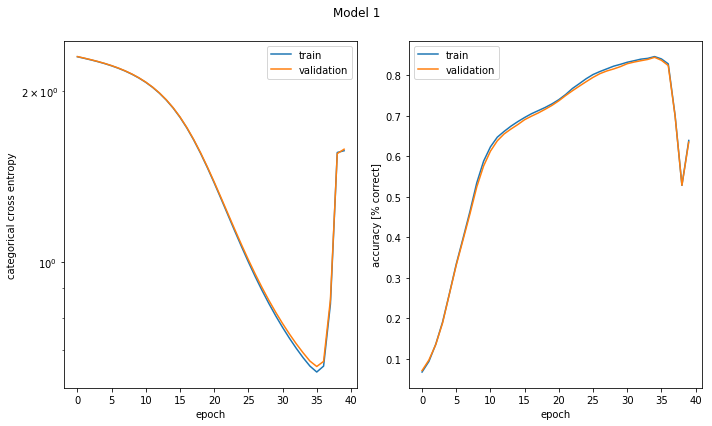

In [10]:
plot_v2(train1, title="Model 1")

In [38]:
test1

(tensor(0.9332), tensor(0.2282), tensor([ 7,  2,  1,  ...,  4,  5,  6]))

In [40]:
test_target[-1,:]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])

In [11]:
model2, train2 = default_net_2(train_input, train_target, num_of_neurons=(784, 100, 100, 10), lr=0.1, momentum_coef=0.0, num_of_epochs=100)
test2 = model2.evaluate(test_input, test_target, return_pred=True)

Added Module Name: 0_Linear 
Added Module Name: 1_ReLU 
Added Module Name: 2_Linear 
Added Module Name: 3_ReLU 
Added Module Name: 4_Linear 
Added Module Name: 5_ReLU 
Added Module Name: 6_Linear 
Added Module Name: 7_Softmax 


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\furkan\Desktop\EPFL\ma\ma2\Deep Learning\project\project2\dl-framework-master\dl-framework-master\modules\losses.py:102: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return loss_val[0]  # TODO: handle this accordingly with take_avg false
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.06s/it]


(tensor(0.9078), tensor(0.3289), tensor([ 7,  2,  1,  ...,  4,  5,  6]))

In [15]:
model3, train3 = default_net_3(train_input_mse, train_target_mse, num_of_neurons=(784, 500, 200, 100, 10), lr=0.1, momentum_coef=0.0, num_of_epochs=100)
test3 = model3.evaluate(test_input_mse, test_target_mse, return_pred=True)

prev: 100, current: 784
Added Module Name: 0_Linear 
Added Module Name: 1_ReLU 
Added Module Name: 2_Dropout 
prev: 100, current: 100
Added Module Name: 3_Linear 
Added Module Name: 4_ReLU 
Added Module Name: 5_Dropout 
prev: 100, current: 100
Added Module Name: 6_Linear 
Added Module Name: 7_ReLU 
Added Module Name: 8_Dropout 
prev: 10, current: 100
Added Module Name: 9_Linear 
Added Module Name: 10_ReLU 


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:23<00:00,  2.04s/it]


(tensor(1.00000e-02 *
        9.8200), tensor(10.), tensor([ 0,  0,  0,  ...,  0,  0,  0]))